# Problem Set 5, due June 2nd 11:59pm (end of day).

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early! Part 4 will give you an opportunity to get some intuition with PCA.

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download pset5.ipynb and the file "reviews.csv" from Canvas.

I suggest you to get familiar with 'groupby' and
_unique_ functions in 'numpy'.  You will probably also need
_CountVectorizer_ in 'sklearn.feature\_extraction.text' and
_MultinomialNB_ in 'sklearn.naive\_bayes'


In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import os


# Introduction

In this assignment, you'll be analyzing movie reviews in an attempt to
determine whether movies are good or bad.  The file "reviews.csv",
contains reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh or Rotten.

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As before, we'll start out with some exploratory data analysis.

# 1 Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data, either missing review or missing fresh/rotten indicator.

In [21]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv('movies.dat', delimiter = '\t')

reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']

## 1.1 Basic features of the dataset

Answer the following questions by having your code directly print the
answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [22]:
# enter your code below
print('Number of unique reviews:', len(reviews))
print('Number of unique reviewers:', len(reviews.critic.unique()))
print('Number of unique movies in reviews:', len(reviews.title.unique()))
print('Number of unique movies in movies:', len(movies.title.unique()))
print('Number of different publications:', len(reviews.publication.unique()))


Number of unique reviews: 13419
Number of unique reviewers: 541
Number of unique movies in reviews: 1720
Number of unique movies in movies: 9405
Number of different publications: 64


## 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

Does the distribution look normal?  Is it what you expect?

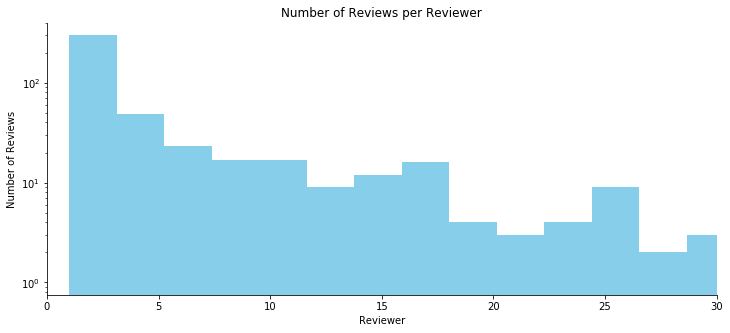

In [47]:
# plot the histogram
x = reviews.critic.value_counts()
plt.figure(figsize = (12, 5))
hist = plt.subplot(111)
hist.hist(x, len(x), color='skyblue')
plt.gca().set_yscale('log')
plt.gca().set_xlim([0,30])

# format the histogram
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(axis='both', which='both', bottom='on', top='off', right = 'off', labelbottom='on')
plt.gca().set_xlabel('Reviewer')
plt.gca().set_ylabel('Number of Reviews')
plt.gca().set_title('Number of Reviews per Reviewer')


_The distribution doesn't look normal. This is what I expected because it is reasonable that there are few people that give a lot of reviews, and there are many people who give only a few reviews. The distribution shows the same pattern that as the number of reviews increases, the number of people that give those review decreases._

## 1.3 Take a closer look of a few reviews

Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function*

In [42]:
# group by critic
critic = reviews.groupby(['critic'], as_index = True)

# aggregate by publication
pub = pd.DataFrame(critic['publication'].agg(max))

# aggregate by review date
dates = pd.DataFrame(critic['review_date'].agg([min, max]))

# select the top 30 critics
top = pd.DataFrame(critic.size().sort_values(ascending = False).head(30)).reset_index()

# join 3 dataframes to get wanted values
top = pd.merge(top, pub, left_on = ['critic'], right_index = True, how = 'left')
top30 = pd.merge(top, dates, left_on = ['critic'], right_index = True, how = 'left')

# trim and rename the columns
top30 = top30[['critic', 'publication', 'min', 'max']]
top30.columns = ['Name', 'Publication', 'First Review Date', 'Last Review Date']

top30


,Name,Publication,First Review Date,Last Review Date
0,Roger Ebert,Chicago Sun-Times,2000-01-01 00:00:00,2013-06-11 00:00:00
1,James Berardinelli,ReelViews,1800-01-01 00:00:00,2012-02-07 00:00:00
2,Janet Maslin,New York Times,2000-01-01 00:00:00,2010-09-07 00:00:00
3,Variety Staff,Variety,2001-02-13 00:00:00,2012-08-15 00:00:00
4,Jonathan Rosenbaum,Chicago Reader,1988-07-11 00:00:00,2013-10-22 00:00:00
5,Desson Thomson,Washington Post,2000-01-01 00:00:00,2012-10-08 00:00:00
6,Geoff Andrew,Time Out,2005-08-11 00:00:00,2012-04-05 00:00:00
7,Dave Kehr,New York Daily News,2000-01-01 00:00:00,2013-11-20 00:00:00
8,Kenneth Turan,Los Angeles Times,2000-01-01 00:00:00,2013-10-05 00:00:00
9,Mick LaSalle,San Francisco Chronicle,2000-01-01 00:00:00,2009-11-25 00:00:00


## 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in red showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

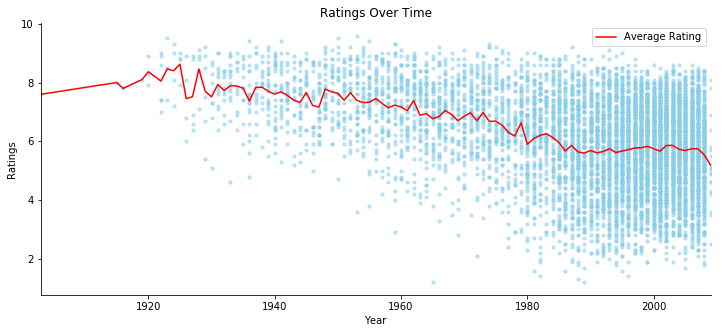

In [63]:
# Drop movies with 0 or unknown values 
movies = pd.read_csv("movies.dat", delimiter='\t')
movies = movies[~movies.rtAllCriticsRating.isnull()]
movies = movies[movies.rtAllCriticsRating != '\\N']
movies = movies[movies.rtAllCriticsRating != '0']

# set appropriate data types
movies['year'] = movies.year.astype(int)
movies['rtAllCriticsRating'] = movies.rtAllCriticsRating.astype(float)

# create a scatterplot that has one point for each remaining movie
scat = movies.plot(kind = 'scatter', x = 'year', y = 'rtAllCriticsRating', alpha = 0.5, s = 10, figsize=(12, 5), c = 'skyblue')

# overlay on this scatterplot a line graph in red showing the average movie rating
movies_by_year = movies.groupby(['year'], as_index = False)
movies_by_year = pd.DataFrame(movies_by_year['rtAllCriticsRating'].agg('mean'))
movies_by_year.plot(ax = scat, kind='line', x='year', y='rtAllCriticsRating', c = 'red', label = 'Average Rating')

# format the plot
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(axis='both', which='both', bottom='on', top='off', right = 'off', labelbottom='on')
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Ratings')
plt.gca().set_title('Ratings Over Time')


_**There is a downward trend of average movie ratings over time.** Also, the minimum rating values kept decreasing over time, while the maximum stayed almost the same. I think it does not necessarily mean that the overall movies quality is becoming worse, because there can be many reasons that may cause this decreasing trend. For example, maybe there were many movie ratings that didn't go to database years ago, or maybe the reviewers' opinion is changing over time._

# Part 2: Naive Bayes

Now it gets fun!  You are going to use a Naive Bayes classifier to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. 

## 2.0 Using CountVectorizer

One thing that may help you in the following problems is the _CountVectorizer_ object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in the text.  (Note: the order of wordss is not preserved in the bag).   Here's a simple example, make sure you understand what's going on!

In [77]:
sentences = ["Next morning when I awakened I found Jem and Dill in the back yard deep in conversation.", "When I joined them, as usual they said go away.", "Will not.", "This yard's as much mine as it is your, Jem Finch.", "I got just as much right to play in it as you have."]
# Harper Lee "To Kill a Mockingbrid"
print("Original text:\n", '\n'.join(sentences))

vectorizer = CountVectorizer(min_df=0)
vectorizer.fit(sentences)
# `fit` builds the vocabulary
x = vectorizer.transform(sentences).toarray()
# `transform` converts text to a bag of words
print("Transformed text vector:\n", x)

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("Words for each feature:")
print(vectorizer.get_feature_names())

Original text:
 Next morning when I awakened I found Jem and Dill in the back yard deep in conversation.
When I joined them, as usual they said go away.
Will not.
This yard's as much mine as it is your, Jem Finch.
I got just as much right to play in it as you have.
Transformed text vector:
 [[1 0 1 0 1 1 1 1 0 1 0 0 0 2 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0
  0]
 [0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0
  0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
  0]
 [0 2 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
  1]
 [0 2 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1
  0]]
Words for each feature:
['and', 'as', 'awakened', 'away', 'back', 'conversation', 'deep', 'dill', 'finch', 'found', 'go', 'got', 'have', 'in', 'is', 'it', 'jem', 'joined', 'just', 'mine', 'morning', 'much', 'next', 'not', 'play', 'right', 'said', 'the', 'them', 'they', 'this', 'to', 'usual', 'when', '

## 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row is the bag-of-words representation for a single review.  This will be the *input* (fetaures) of your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* (target) from your model.
 
 Make sure to remove items with no review text

Feel free to use the _make\_xy_ function below to achieve it, but you can also create your own parser.

In [66]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    Y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, Y

X, Y = make_xy(reviews)
X, Y

(<13419x20875 sparse matrix of type '<class 'numpy.int64'>'
 	with 242600 stored elements in Compressed Sparse Column format>,
 array([1, 1, 1, ..., 1, 0, 0]))

## 2.2 Test-Train split

Next, randomly split the data into two groups: a training (75%) set and a validation set (25%).  You can do this manually, as you have done earlier, but I recommend to use `train_test_split` in 'sklearn.model_selection'.

In [69]:
xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, Y, test_size = 0.25)

# verify shapes
print (xtrain.shape, ytrain.shape)
print (xtest.shape, ytest.shape)

(10064, 20875) (10064,)
(3355, 20875) (3355,)


## 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the `MultinomialNB` from 'sklearn'.  Play with _MultinomialNB_ parameters.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [75]:
import sklearn.naive_bayes as nb

# fit naive bayes model on the training set
model = nb.MultinomialNB()
model.fit(xtrain, ytrain)

# predict target value using training data and testing data
ytrain_hat = model.predict(xtrain)
ytest_hat = model.predict(xtest)

# report accuracy on the training set and testing set
print('Training accuracy:', round(np.mean(ytrain_hat == ytrain), 4))
print('Test accuracy:', round(np.mean(ytest_hat == ytest), 4))


Training accuracy: 0.9241
Test accuracy: 0.7782


_The accuracy of this model on the training data is 0.9241, and on the testing data is 0.7782. The accuracy on training data is very good, but on the testing data it is much lower. This indicates that using a Naive Bayes classifier from MultinomialNB to fit the data may cause a over-fitting problem, so that the accuracy on test set is not that satisfying._

## 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!

That was almost too easy, right?  Right.

Your next mission, if you feel you want to take an extra challenge, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on Canvas).  

**Note:** Do this *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [138]:
import math

def nbayes(xtrain, ytrain, xtest):
    xtest = xtest.toarray()
    xtrain = xtrain.toarray()
    
    y_class, class_counts = np.unique(ytrain, return_counts = True)
    
    # calculate probabilities
    priors = class_counts.astype(float) / len(ytrain)
    
    conditionals = []
    # split training data by class and calculate maximum likelihood
    for cl in y_class:
        x_by_class = xtrain[np.where(ytrain==cl)]
        x_mle = x_by_class.sum(axis=0).astype(float)/len(x_by_class.sum(axis=0))
        conditionals.append(x_mle)
    
    conditionals = np.array(conditionals)
    cond_probs = np.dot(conditionals, xtest.T)
    
    # add log probs of prior and conditional 
    yhat = np.add(np.log(priors), np.log(cond_probs).T).T
    yhat = math.e**yhat
    yhat = yhat / np.sum(yhat, axis = 0)
        
    return yhat

# test the function using test and training sets
y_hat = nbayes(xtrain,ytrain,xtest)

print('Test accuracy is:' ,(np.mean(np.argmax(y_hat, axis = 0) == ytest)))

Test accuracy is: 0.626117734724


/Users/Amit/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log
/Users/Amit/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in true_divide


# 3 Evaluation

## 3.1 Estimate the likelihood of your data

Calculate log-likelihood of a fitted model.  Log-likelihood is a way to assess the performance of your model.  Remeber -- likelihood is more-or-less the probability to observe your data (including your target).  Below is an example function that calculates the log-likelihood of an estimated model using `fitted_model.predict_logproba`.  You may use this function, or write your own.  

In [76]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 

The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews.

Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    # returns Nx2 array.  Columns are log(Pr(y == 0|x)), log(Pr(y==1|x))
    ll = prob[y == 0, 0].sum() + prob[y == 1, 1].sum()
    return ll

log_likelihood(model, xtest, ytest)

-1820.7230165025294

## 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The `alpha` keyword in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

We are going to use cross-validation to tune these hyperparameters.  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.model_selection.cross_val_score`, that might save you a lot of time here...*

In [139]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

res_alpha = 0
res_min_df = 0
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        # choose vectorizer with min_df
        vectorizer = CountVectorizer(min_df = min_df)       
        
        # build bag-of-words matrix (X) and 1/0 array (Y)
        X, Y = make_xy(reviews, vectorizer)
        
        # define naive bayes model with alpha
        fitted_model = MultinomialNB(alpha=alpha)
        
        # estimate log likelihood on test data
        score = cross_validation.cross_val_score(fitted_model, X, Y, scoring = log_likelihood).mean()
        
        print(alpha, min_df, score)
        
        # update the result values
        if score > max_loglike:
            max_loglike = score
            res_alpha = alpha
            res_min_df = min_df

print('Best alpha is:', res_alpha, 'Best min_def is:', res_min_df, 'Max loglike is:', max_loglike)


/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/utils/extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  out = np.log(np.sum(np.exp(arr - vmax), axis=0))
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/utils/extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  out = np.log(np.sum(np.exp(arr - vmax), axis=0))
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/utils/extmath.py:410: RuntimeWarning: invali

0 1e-05 nan


/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/utils/extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  out = np.log(np.sum(np.exp(arr - vmax), axis=0))
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/utils/extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  out = np.log(np.sum(np.exp(arr - vmax), axis=0))
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/utils/extmath.py:410: RuntimeWarning: invali

0 0.0001 nan


/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/utils/extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  out = np.log(np.sum(np.exp(arr - vmax), axis=0))
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/utils/extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  out = np.log(np.sum(np.exp(arr - vmax), axis=0))
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/utils/extmath.py:410: RuntimeWarning: invali

0 0.001 nan
0 0.01 -2807.60550331
0 0.1 -2908.06027747
0.1 1e-05 -3922.81445287
0.1 0.0001 -3920.80980545
0.1 0.001 -2788.26008898
0.1 0.01 -2807.31820944
0.1 0.1 -2908.05876678
1 1e-05 -2684.16233569
1 0.0001 -2633.08384867
1 0.001 -2612.04885544
1 0.01 -2804.87652365
1 0.1 -2908.04543903
5 1e-05 -4569.6089708
5 0.0001 -3274.02664404
5 0.001 -2482.89345479
5 0.01 -2796.60258611
5 0.1 -2907.99194518
10 1e-05 -6208.43842155
10 0.0001 -4676.48956883
10 0.001 -2534.25708801
10 0.01 -2790.52234972
10 0.1 -2907.93779446
50 1e-05 -7732.17656358
50 0.0001 -7064.92626789
50 0.001 -4141.08834896
50 0.01 -2818.62772991
50 0.1 -2907.93436322
Best alpha is: 5 Best min_def is: 0.001 Max loglike is: -2482.89345479


## 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [90]:
# create and fit vectorizer
vectorizer = CountVectorizer(min_df = res_min_df)       
X, Y = make_xy(reviews, vectorizer)

# split X,Y into training and test sets
xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, Y, test_size=0.4, random_state=97531)

# fit NB model using training data
fitted_model = MultinomialNB(alpha= 10, class_prior=None, fit_prior=True)
fitted_model.fit(xtrain, ytrain)

# predict target values for model using training set
ytrain_hat = fitted_model.predict(xtrain)
# compute accuracy on training data
print('Training accuracy:', np.mean(ytrain_hat == ytrain))

ytest_hat = fitted_model.predict(xtest)
print('Test accuracy:', np.mean(ytest_hat == ytest))

Training accuracy: 0.769593839275
Test accuracy: 0.721684053651


_The new model is less accurate, but the overfitting is less._

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [142]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

res_alpha = 0
res_min_df = 0
max_loglike = -np.inf

def predict_ac(model, x,y):
    y_hat = model.predict(x)
    return np.mean(y_hat == y)

for alpha in alphas:
    for min_df in min_dfs:         
        # choose vectorizer with min_df
        vectorizer = CountVectorizer(min_df = min_df)       
        # build bag-of-words matrix (X) and 1/0 array (Y)
        X, Y = make_xy(reviews, vectorizer)
        # define naive bayes model with alpha
        fitted_model = MultinomialNB(alpha=alpha)
        score = cross_validation.cross_val_score(fitted_model, X, Y, scoring = predict_ac).mean()
        
        print(alpha, min_df, score)
        
        # update values
        if score > max_loglike:
            max_loglike = score
            best_alpha = alpha
            best_min_df = min_df
    
print('Best alpha is:', res_alpha, 'Best min_def is:', res_min_df, 'Max loglike is:', max_loglike)


/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


0 1e-05 0.549520056262


/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


0 0.0001 0.600492359856


/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


0 0.001 0.73418208327
0 0.01 0.661523726222
0 0.1 0.625978161654
0.1 1e-05 0.738653738514
0.1 0.0001 0.738802397742
0.1 0.001 0.73649244053
0.1 0.01 0.661523726222
0.1 0.1 0.625978161654
1 1e-05 0.761681107055
1 0.0001 0.760861290514
1 0.001 0.7379826647
1 0.01 0.661300145946
1 0.1 0.625903657109
5 1e-05 0.669424373278
5 0.0001 0.710113633681
5 0.001 0.730753841314
5 0.01 0.660778647446
5 0.1 0.625903690429
10 1e-05 0.63939237814
10 0.0001 0.654669191589
10 0.001 0.722109831408
10 0.01 0.659064793024
10 0.1 0.625978244951
50 1e-05 0.625605472283
50 0.0001 0.625605472283
50 0.001 0.635144419633
50 0.01 0.65653128867
50 0.1 0.626350834301
Best alpha is: 0 Best min_def is: 0 Max loglike is: 0.761681107055


_Compared to the previous results, both the best alpha value and the best min def value had decreased, and the maximum log likelihood changed to 0.76. _

## 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [91]:
# get top 10 "totten" words
vectorizer = CountVectorizer(min_df = .0001)       

# build bag-of-words matrix
X, Y = make_xy(reviews, vectorizer)


fitted_model = MultinomialNB(alpha=1, class_prior=None, fit_prior=True)
fitted_model.fit(X, Y)
probs = fitted_model.predict_proba(np.identity(X.shape[1]))

# split into rotten and fresh vectors of probabilities
rotten_probs = probs[:,0]
fresh_probs = probs[:,1]

# get the indices of the 10 words associated with rotten that have the highest probabilities
rotten_feat_idx = np.argpartition(rotten_probs, -10, axis = 0)[-10:]

rotten_names = np.array(vectorizer.get_feature_names())
rotten_names = rotten_names[rotten_feat_idx]
rotten_probs = np.array(rotten_probs[rotten_feat_idx])

# create a dataframe with top ten rotten words and probability from above arrays
rotten10 = pd.DataFrame({'Top Rotten Words': rotten_names, 'Rotten Probability': rotten_probs})
rotten10.sort_values(['Rotten Probability'], ascending = 0, inplace = True)
rotten10.reset_index(inplace = True, drop = True)

print(rotten10)


   Rotten Probability Top Rotten Words
0            0.963114             lame
1            0.961749        pointless
2            0.955107       uninspired
3            0.955107    unfortunately
4            0.942660            sadly
5            0.942660         tiresome
6            0.931218  disappointingly
7            0.926317            tepid
8            0.926317        obnoxious
9            0.926317          witless


In [92]:
# get top 10 "fresh" words
fresh_feat_idx = np.argpartition(fresh_probs, -10, axis = 0)[-10:]

fresh_names = np.array(vectorizer.get_feature_names())
fresh_names = fresh_names[fresh_feat_idx]
fresh_probs = np.array(fresh_probs[fresh_feat_idx])

# create a dataframe with top 10 fresh words and probability from above arrays
fresh10 = pd.DataFrame({'Top Fresh Words': fresh_names, 'Fresh Probability': fresh_probs})
fresh10.sort_values(['Fresh Probability'], ascending = 0, inplace = True)
fresh10.reset_index(inplace = True, drop = True)

print(fresh10)

   Fresh Probability Top Fresh Words
0           0.978005         delight
1           0.965422        intimate
2           0.962759        captures
3           0.959651            myth
4           0.959651       childhood
5           0.957894         rousing
6           0.955977       seductive
7           0.953878        expertly
8           0.953878   unforgettable
9           0.951568     astonishing


_The top 10 "rotten" words are: lame, pointless, uninspired, unfortunately, sadly, tiresome, disappointingly, tepid, obnoxious, and witless. The top 10 "fresh" words are: delight, intimate, captures, myth, childhood, rousing, seductive, expertly, unforgettable, and astonishing. These words are commonly used in movie reviews that are related to these two kinds of emotions._

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [102]:
def mis_predict(model, X, Y):
    prob = model.predict_proba(X)
    return abs(Y - prob[:, 1])

prob_results = mis_predict(fitted_model, X, Y)
mis_df = pd.DataFrame({'Prob Predict Diff': prob_results, 'Y': Y, 'Reviews': reviews.quote})

# sort the results and show top 10 reviews
top_mis = mis_df.sort_values('Prob Predict Diff', ascending = False).head(10)

print(top_mis, '\n')

for i in range(10):
    print(i+1, '.', top_mis.Reviews.iloc[i], '\n')

       Prob Predict Diff                                            Reviews  Y
12515           0.999694  This pacifist spirit of brotherhood echoes the...  0
5400            0.999353  Some of the gags don't work, but fewer than in...  1
8621            0.998919  There's too much talent and too strong a story...  1
8718            0.998617  If it's to be experienced at all, Return to Pa...  0
9463            0.998321  The Waterboy is arguably Sandler's most enjoya...  0
1715            0.998278  The gangland plot is flimsy (bad guy Peter Gre...  1
10973           0.997449  Certain, probably arrested, personalities (lik...  1
6293            0.997377  It's a sad day when an actor who's totally, be...  0
7871            0.997344  There is only one problem with the excitement ...  1
7243            0.997330  Walken is one of the few undeniably charismati...  0 

1 . This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap betw

## Part 4: Principal Component Analysis

Just when you thought you were *finally* done with the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing), it has come back to haunt you for a few more minutes.  Make sure you're up and running as you were on the previous problem set:

In [78]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston
bdata = load_boston()

### 4.1 Remember the last problem set?

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional.  If you didn't get full credit for this on the first problem set, get full credit this time!

Then, just as you did on the previous problem set, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to regress median housing price on average number of rooms per house.  Use a training set consisting of 66% of your instances to fit your regression model.  Report the RMSE on the training and test set.

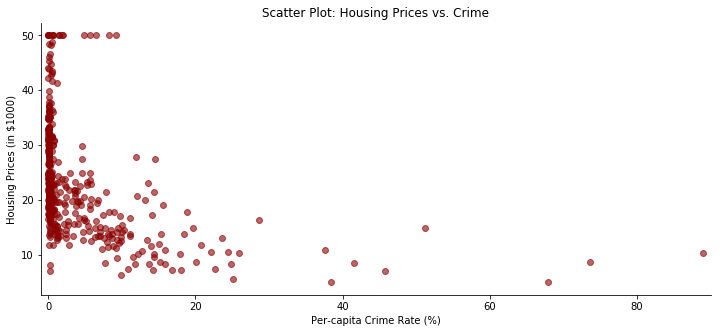

In [81]:
# generate a plot of fixed size
plt.figure(figsize = (12, 5))
scat = plt.subplot(111)

# insert a new column in the 2 dimensional array "data" to store the target value
new_data = np.insert(bdata.data, bdata.data.shape[1], bdata.target, axis = 1)

# plot the scatter plot
scat.scatter(new_data[:, 0], new_data[:, 13], color = 'darkred', alpha = 0.6)

# Remove the axes on the top and right side of the plot window
scat.spines['right'].set_visible(False)
scat.spines['top'].set_visible(False)
scat.yaxis.set_ticks_position('left')
scat.xaxis.set_ticks_position('bottom')

# Add appropriate labels to the x and y axes, make sure to include units
plt.xlabel('Per-capita Crime Rate (%)')
plt.ylabel('Housing Prices (in $1000)')
plt.title('Scatter Plot: Housing Prices vs. Crime')

# Adjust x-axis limit
plt.xlim([new_data[:,0].min()-1, new_data[:,0].max()+1])

plt.show()

In [84]:
from numpy import sqrt
np.random.seed(seed=13579)

def divide(data, percentage):
    '''this function takes 2 parameters: data and percentage of training dataset,
    then it divides the dataset into training and testing datasets by firstly random shuffle 
    the input data and then cut the length of rows by corresponding percentage. Finally it
    returns 2 datasets: training and testing'''
    np.random.shuffle(data)
    train = data[0:percentage*len(data), :]
    test = data[percentage*len(data):, :]
    return train, test

# Divide the new_data dataset into 66% training and 34% testing
data_train, data_test = divide(new_data, 0.66)

def compute_rmse(predictions, yvalues):
    rmse = np.sqrt(np.mean((predictions-yvalues)**2))
    return round(rmse, 2)

print('Train RMSE:',compute_rmse([data_train[:,13].mean()], data_train[:,13]))
print('Test RMSE:',compute_rmse([data_train[:,13].mean()], data_test[:,13]))

Train RMSE: 9.54
Test RMSE: 8.47


/Users/Amit/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Amit/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### 4.2 So many scatterplots!

Choose 8 out of the of the 14 features of the housing data that you think are most interesting to study.  Create an 8x8 grid of scatterplots showing how each of these variables relate to each other.  You want to produce something that looks generally like [this image](http://iogas.net/wp-content/gallery/iogas-evaluation/scatterplot-matrix-point-density.png).

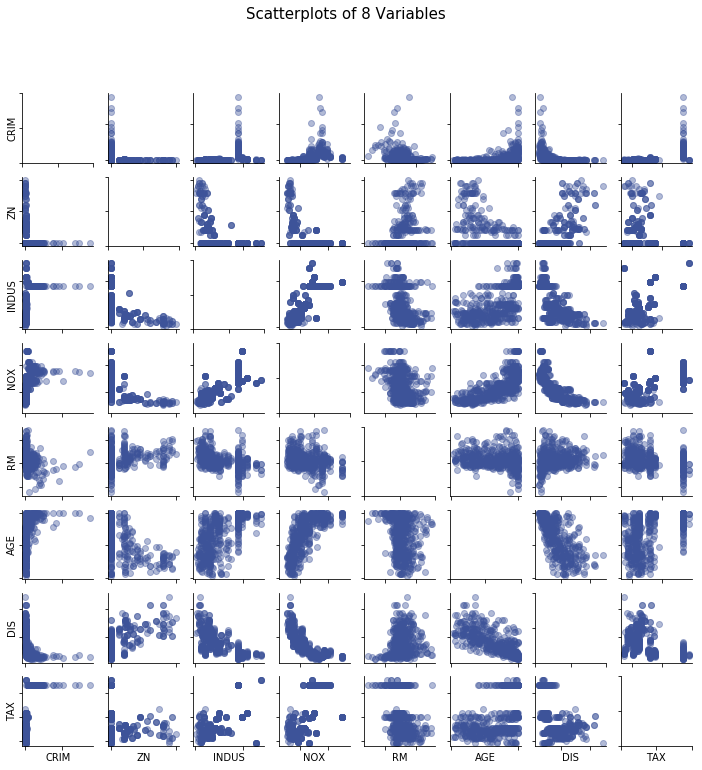

In [108]:
# define features to be included
features_of_interest = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX']

# get the indices of the feature names in the features of interest set
feat = np.in1d(bdata.feature_names, features_of_interest)

# filter for interest features, create new ndarray
bdata.data_8 = bdata.data[:,feat]

# set plot space, give title
plt.figure(figsize=(12,12))
plt.suptitle('Scatterplots of 8 Variables', fontsize = 15)

for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, i * 8 + j + 1)
        # set variables for plot
        y = np.vstack(bdata.data_8[:,i])
        x = np.vstack(bdata.data_8[:,j]) 

        # create scatter plot of j x i features
        if j != i:
            plt.scatter(x, y, color = '#3D5399', alpha =0.4)
        
        # format the plot
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.tick_params(axis='both', which='both', bottom='on', top='off', right = 'off', labelbottom='on')
        
        if j == 0:
            plt.ylabel(features_of_interest[i], labelpad=-2)
        if i == 7:
            plt.xlabel(features_of_interest[j], labelpad=0)
            
        plt.gca().axes.get_xaxis().set_ticklabels([])
        plt.gca().axes.get_yaxis().set_ticklabels([])

### 4.3 PCA to the rescue

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn to find the first 12 principal components of your data.  Use only your training set (66% of the data), and use all features *except* the median housing price.  Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 12.

{1: 80.306947987796747, 2: 96.815047066670559, 3: 98.898192554478243, 4: 99.554669675843257, 5: 99.76848261392432, 6: 99.889863166421492, 7: 99.933332715956197, 8: 99.968079563454538, 9: 99.989338000300094, 10: 99.996265878929918, 11: 99.999235631895615, 12: 99.999841395525365}


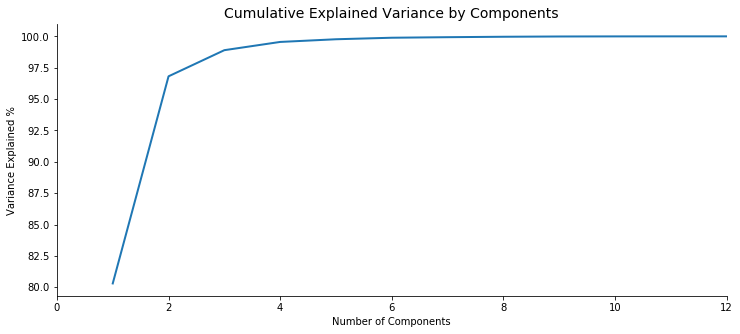

In [121]:
plt.figure(figsize = (12, 5))
line = plt.subplot(111)

# create dictionary to hold components and their variances explained
var = {}
for p in range(12):
    # fit pca
    pca = PCA(n_components = p + 1)
    pca.fit(data_train)
    
    # calculate variance ratio
    var_ratio = sum(pca.explained_variance_ratio_)*100
    
    # update dictionary
    var[p + 1] = var_ratio
    
print(var)
keys = list(var.keys())
vals = list(var.values())

# plot variance explained / components
line.plot(keys, vals, linewidth = 2)

# format the plot
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(axis='both', which='both', bottom='on', top='off', right = 'off', labelbottom='on')

# set x axis limits
plt.gca().set_xlim([0,12])

# apply labels
plt.gca().set_xlabel('Number of Components')
plt.gca().set_ylabel('Variance Explained %')
plt.gca().set_title('Cumulative Explained Variance by Components', fontsize = 14)

### 4.4 Visualizing the components

Create a 1X3 grid containing three scatter plots of your training data:

1. PCA 1 vs. PCA 2 (you will need to use `fit_transform` to project your training data onto these two components)
2. PCA 1 (x-axis) vs. median housing value
3. PCA 2 vs. median housing value

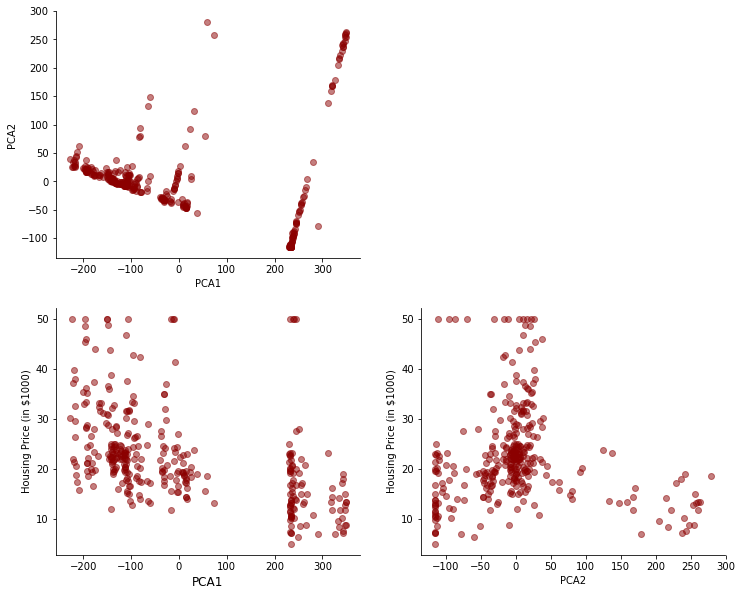

In [125]:
pca = PCA(n_components = 12)
pca.fit(data_train)

# transform the data for plots
pca1 = pca.fit_transform(data_train)[:,0]
pca2 = pca.fit_transform(data_train)[:,1]

# define figure space
fig = plt.figure(figsize=(12, 10))

# plot first scatter plot
ax1 = fig.add_subplot(221)
ax1.scatter(pca1, pca2, color = 'darkred', alpha = 0.5)

# format the plot
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(axis='both', which='both', bottom='on', top='off', right = 'off', labelbottom='on')
plt.gca().set_xlabel('PCA1')
plt.gca().set_ylabel('PCA2')

# plot second scatter plot
ax2 = fig.add_subplot(223)
ax2.scatter(pca1, data_train[:,13], color = 'darkred', alpha = 0.5)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(axis='both', which='both', bottom='on', top='off', right = 'off', labelbottom='on')
plt.gca().set_xlabel('PCA1')
plt.gca().set_ylabel('PCA2')

plt.gca().set_xlabel('PCA1', fontsize = 12)
plt.gca().set_ylabel('Housing Price (in $1000)')

# plot third scatter plot
ax2 = fig.add_subplot(224)
ax2.scatter(pca2, data_train[:,13], color = 'darkred', alpha = 0.5)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(axis='both', which='both', bottom='on', top='off', right = 'off', labelbottom='on')
plt.gca().set_xlabel('PCA1')
plt.gca().set_ylabel('PCA2')

plt.gca().set_xlabel('PCA2')
plt.gca().set_ylabel('Housing Price (in $1000)')

### 4.5 Regression and PCA

Using just the first Principal Component learned on the training data, project all of your data (including the test data) onto this 1-dimensional subspace using the `fit_transform` function.  Now, using your training data, fit a regression of median housing price on this first principal component of your data.  Report the RMSE of this regression for both the training and test set.  How do these results compare to your results from 4.1?  Interpret your results!

In [131]:
# fit PCA model with 1 component
pca1 = PCA(n_components = 1)
pca1.fit(data_train)

# transform using training and test data
pca1_train = pca1.fit_transform(data_train)
pca1_test = pca1.fit_transform(data_test)

# create linear regression and fit training data
lr = LinearRegression()
lr.fit(pca1_train, data_train[:, 13])

# predict values using the training set
data_train_hat = lr.predict(pca1_train)

# predict using test set
data_test_hat = lr.predict(pca1_test)

# calculate and report RMSE
print('Training RMSE:', str(compute_rmse(data_test_hat, data_test[:,13])))
print('Testing RMSE:', str(compute_rmse(data_train_hat, data_train[:,13])))

Training RMSE: 7.36
Testing RMSE: 8.34


_The RMSE of this regression for the training set is 7.36, and for the testing set is 8.34. Comparing to the results from 4.1, the one component PCA model produced a slightly poorer performance than using the RM feature in linear regression model. The difference between RMSE for training and testing set is about 1, which is slightly larger than previous results, indicating that there is also overfitting problem._